# Quem será o vencedor?

*Começaremos importando as bibliotecas necessárias.*

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
## Abaixo estou colocando o número de colunas visível máximo no head para 100
pd.set_option('display.max_columns',100)

*Percebemos que o dataset possui 1520 jogos e 21 colunas.*

In [2]:
bd = pd.read_csv('datasets/dataset_completo.csv',sep=',')
print('Tamanho: ' + str(bd.shape))
bd.tail()

Tamanho: (1900, 25)


,Unnamed: 0,Ano,Rodada,Mandante,Gols_Mandante,Gols_Visitante,Visitante,Vencedor,TC-Valor,TV-Valor,TC-Media_Gols,TV-Media_Gols,TC-Ofensivo,TV-Defensivo,TC-Empates_Casa,TC-Jogos_Fora,TC-Derrotas_Fora,TC-Pontos,TC-Fator_Campo,TV-Vitorias_Casa,TV-Derrotas_Casa,TV-Gols_Casa,TV-Gols_Fora,TV-Gols_Sofridos,TV-Pontos
1895,1895,2019.0,38.0,Vasco,1.0,1.0,Chapecoense,0.0,38.05,28.75,1.4,1.0,0.0758,0.1157,5.0,19.0,7.0,48.0,0.65,4.0,10.0,35.0,14.0,51.0,31.0
1896,1896,2019.0,38.0,Botafogo,1.0,1.0,Ceara,0.0,30.95,19.68,0.4,0.6,0.0713,0.1030,1.0,19.0,13.0,42.0,0.77,8.0,5.0,41.0,12.0,40.0,38.0
1897,1897,2019.0,38.0,Avai,0.0,0.0,Athletico-PR,0.0,12.25,35.30,0.4,1.0,0.0395,0.0830,8.0,19.0,15.0,19.0,0.82,12.0,4.0,36.0,25.0,32.0,63.0
1898,1898,2019.0,38.0,Goias,3.0,2.0,Gremio,1.0,21.80,71.35,1.8,1.4,0.1105,0.0710,3.0,19.0,11.0,49.0,0.81,12.0,4.0,66.0,24.0,36.0,65.0
1899,1899,2019.0,38.0,CSA,1.0,2.0,Sao Paulo,2.0,25.58,75.20,0.4,0.8,0.0631,0.0671,5.0,19.0,14.0,32.0,0.85,10.0,3.0,39.0,14.0,29.0,60.0


*Abaixo veremos os tipos de cada coluna.*

In [30]:
bd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1520 entries, 0 to 1519
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Ano               1520 non-null   int64  
 1   Rodada            1520 non-null   int64  
 2   Mandante          1520 non-null   object 
 3   Gols_Mandante     1520 non-null   int64  
 4   Gols_Visitante    1520 non-null   int64  
 5   Visitante         1520 non-null   object 
 6   Vencedor          1520 non-null   int64  
 7   TC-Empates_Casa   1520 non-null   int64  
 8   TC-Jogos_Fora     1520 non-null   int64  
 9   TC-Derrotas_Fora  1520 non-null   int64  
 10  TC-Valor          1520 non-null   float64
 11  TC-Pontos         1520 non-null   int64  
 12  TV-Vitorias_Casa  1520 non-null   int64  
 13  TV-Derrotas_Casa  1520 non-null   int64  
 14  TV-Gols_Casa      1520 non-null   int64  
 15  TV-Gols_Fora      1520 non-null   int64  
 16  TV-Gols_Sofridos  1520 non-null   int64  


#### Count Encoder
*Aqui usarei a estratégia de codificação das variáveis categóricas Mandante e Visitante, usando o Count Encoder. A idea principal é colocar o número de vezes que o time disputou o campeonato, sendo assim, na minha hipótese, um time que disputou muito mais vezes o campeonato brasileiro teria mais chance de ganhar o jogo de um que disputou poucas vezes.*

In [3]:
cat_features = ['Mandante','Visitante']

encoder = ce.CountEncoder(cols=cat_features)
encoded = encoder.fit_transform(bd[cat_features])

bd = bd.join(encoded.add_suffix('_count'))

In [4]:
bd['Mandante_target'] = bd['Mandante_count']/bd['Mandante_count'].max()
bd['Visitante_target'] = bd['Visitante_count']/bd['Visitante_count'].max()

*E a partir desse gráfico, temos a hipótese provada: Em que um time mandante com mais particpações no campeonato brasileiro, é mais propenso a ganhar o que um time que participou menas vezes.*
*E também podemos aferir que o mandante também tem mais chances de ganhar.*

([<matplotlib.axis.YTick at 0x7f3b46cc4850>,
 <a list of 3 Text yticklabel objects>)

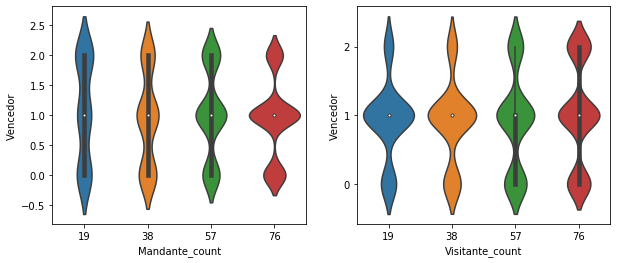

In [5]:
fig, ax = plt.subplots(1,2,figsize=(10,4))

plt.yticks([0,1,2])
sns.violinplot(bd['Mandante_count'],bd['Vencedor'],ax=ax[0])

sns.violinplot(bd['Visitante_count'],bd['Vencedor'],ax=ax[1])
plt.yticks([0,1,2])

### Normalizando valor

*Aqui, normalizaremos o valor de um time no intuito de contornar o problema do elevado intervalo dos valores.*

In [5]:
bd['TC-Valor_norm'] = (bd['TC-Valor'] - bd['TC-Valor'].min())/(bd['TC-Valor'].max() - bd['TC-Valor'].min())
bd['TV-Valor_norm'] = (bd['TV-Valor'] - bd['TV-Valor'].min())/(bd['TV-Valor'].max() - bd['TV-Valor'].min())

In [7]:
bd.head()

,Unnamed: 0,Ano,Rodada,Mandante,Gols_Mandante,Gols_Visitante,Visitante,Vencedor,TC-Valor,TV-Valor,TC-Media_Gols,TV-Media_Gols,TC-Ofensivo,TV-Defensivo,TC-Empates_Casa,TC-Jogos_Fora,TC-Derrotas_Fora,TC-Pontos,TC-Fator_Campo,TV-Vitorias_Casa,TV-Derrotas_Casa,TV-Gols_Casa,TV-Gols_Fora,TV-Gols_Sofridos,TV-Pontos,Mandante_count,Visitante_count,Mandante_target,Visitante_target,TC-Valor_norm,TV-Valor_norm
0,0,2015.0,1.0,Chapecoense,2.0,1.0,Coritiba,1.0,8.20,17.55,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,76,57,1.0,0.75,0.005338,0.190657
1,1,2015.0,1.0,Palmeiras,2.0,2.0,Atletico-MG,0.0,61.95,53.93,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,76,76,1.0,1.00,0.642942,0.585877
2,2,2015.0,1.0,Fluminense,1.0,0.0,Joinville,1.0,66.35,25.67,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,76,19,1.0,0.25,0.695136,0.278870
3,3,2015.0,1.0,Gremio,3.0,3.0,Ponte Preta,0.0,39.48,9.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,76,57,1.0,0.75,0.376394,0.098859
4,4,2015.0,1.0,Cruzeiro,0.0,1.0,Corinthians,2.0,63.25,53.80,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,76,76,1.0,1.00,0.658363,0.584465


### Matriz de Correlação

*Na matriz de correlação abaixo, estamos usando o método de Pearson, ou seja, avalia a relação linear entre 2 variáveis contínuas.*

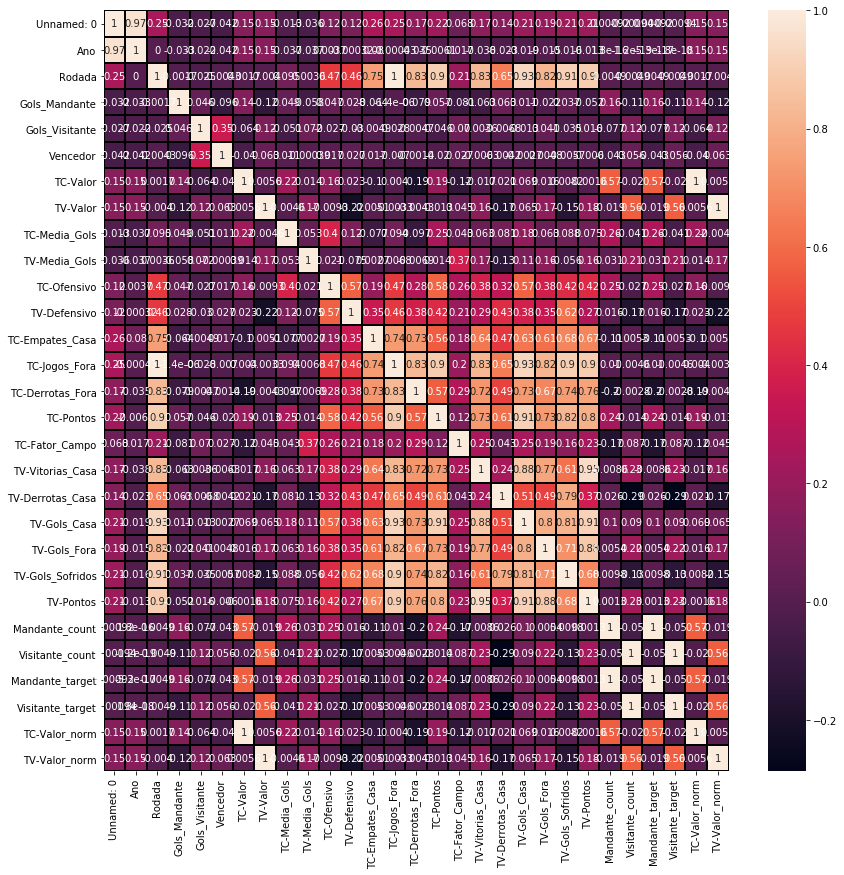

In [10]:
plt.figure(figsize=(14,14));
sns.heatmap(bd.corr(),annot=True, linewidths=1, linecolor='k')

*Na matriz de correlação abaixo, estamos usando o método de Spearman, ou seja, avalia a relação linear entre 2 variáveis contínuas ou ordinais.*

*Para esse trabalho, usarei a correlação de spearman, devido sua abrangência e pelo fato de termos variáves ordinais.*

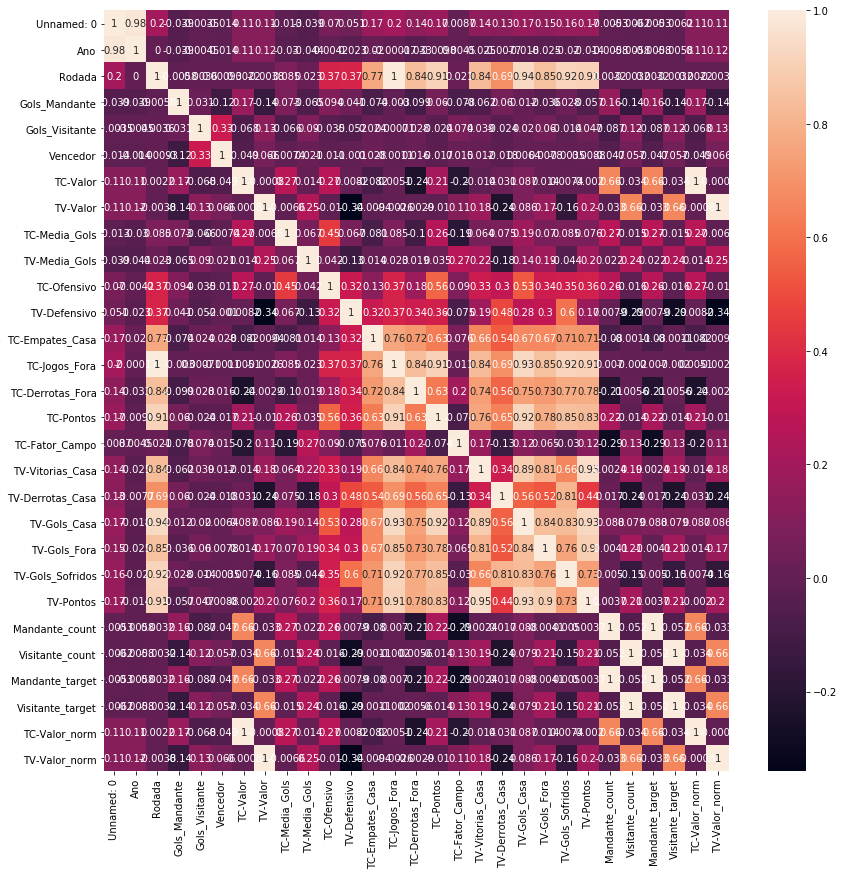

In [32]:
plt.figure(figsize=(14,14));
sns.heatmap(bd.corr(method='spearman'),annot=True, linecolor='k')

### PCA

*Como percebermos na matriz acima, algumas colunas apresentam correlação acima de 90%, ou seja, muito forte. Para não perdermos informações interessantes, iremos aplicar o método PCA. O PCA (Principal Component Analysis) tem como objetivo reduzir a dimensão do dataset, mas preservando ao máximo suas propriedades.*

In [6]:
k = bd[['TV-Vitorias_Casa','TV-Pontos','TV-Gols_Casa']]

In [7]:
scaler = StandardScaler()
scaler.fit(k)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [8]:
scaled_data = scaler.transform(k)
pca = PCA(n_components=k.shape[1])
pca.fit(scaled_data)

PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [9]:
x_pca = pca.transform(scaled_data)

In [10]:
lista = []
lista = list(pca.explained_variance_ratio_)

*Uma componente explica cerca de 95% dos dados.*

In [11]:
df_pca = pd.DataFrame()
df_pca[0] = range(0,k.shape[1])
df_pca[1] = lista
df_pca.tail()

,0,1
0,0,0.941066
1,1,0.043835
2,2,0.015099


In [12]:
a = pd.DataFrame(x_pca[:,:-2])
a.tail()

,0
1895,0.341174
1896,1.484700
1897,2.874447
1898,3.971585
1899,2.525574


In [13]:
c = ['Unnamed: 0','TC-Valor','TV-Valor','Ano','Gols_Mandante','Gols_Visitante','Mandante','Visitante','Mandante_count','Visitante_count','TV-Vitorias_Casa','TV-Pontos','TV-Gols_Casa']

In [14]:
b = pd.DataFrame(bd.drop(c,axis=1))
b.tail()

,Rodada,Vencedor,TC-Media_Gols,TV-Media_Gols,TC-Ofensivo,TV-Defensivo,TC-Empates_Casa,TC-Jogos_Fora,TC-Derrotas_Fora,TC-Pontos,TC-Fator_Campo,TV-Derrotas_Casa,TV-Gols_Fora,TV-Gols_Sofridos,Mandante_target,Visitante_target,TC-Valor_norm,TV-Valor_norm
1895,38.0,0.0,1.4,1.0,0.0758,0.1157,5.0,19.0,7.0,48.0,0.65,10.0,14.0,51.0,0.8,1.0,0.238959,0.213675
1896,38.0,0.0,0.4,0.6,0.0713,0.1030,1.0,19.0,13.0,42.0,0.77,5.0,12.0,40.0,0.8,0.4,0.182965,0.146265
1897,38.0,0.0,0.4,1.0,0.0395,0.0830,8.0,19.0,15.0,19.0,0.82,4.0,25.0,32.0,0.6,1.0,0.035489,0.262356
1898,38.0,1.0,1.8,1.4,0.1105,0.0710,3.0,19.0,11.0,49.0,0.81,4.0,24.0,36.0,0.4,1.0,0.110804,0.530286
1899,38.0,2.0,0.4,0.8,0.0631,0.0671,5.0,19.0,14.0,32.0,0.85,3.0,14.0,29.0,0.2,1.0,0.140615,0.558900


In [17]:
df = pd.concat([a,b],axis=1)
df.tail()

,0,Rodada,Vencedor,TC-Media_Gols,TV-Media_Gols,TC-Ofensivo,TV-Defensivo,TC-Empates_Casa,TC-Jogos_Fora,TC-Derrotas_Fora,TC-Pontos,TC-Fator_Campo,TV-Derrotas_Casa,TV-Gols_Fora,TV-Gols_Sofridos,Mandante_target,Visitante_target,TC-Valor_norm,TV-Valor_norm
1895,0.341174,38.0,0.0,1.4,1.0,0.0758,0.1157,5.0,19.0,7.0,48.0,0.65,10.0,14.0,51.0,0.8,1.0,0.238959,0.213675
1896,1.484700,38.0,0.0,0.4,0.6,0.0713,0.1030,1.0,19.0,13.0,42.0,0.77,5.0,12.0,40.0,0.8,0.4,0.182965,0.146265
1897,2.874447,38.0,0.0,0.4,1.0,0.0395,0.0830,8.0,19.0,15.0,19.0,0.82,4.0,25.0,32.0,0.6,1.0,0.035489,0.262356
1898,3.971585,38.0,1.0,1.8,1.4,0.1105,0.0710,3.0,19.0,11.0,49.0,0.81,4.0,24.0,36.0,0.4,1.0,0.110804,0.530286
1899,2.525574,38.0,2.0,0.4,0.8,0.0631,0.0671,5.0,19.0,14.0,32.0,0.85,3.0,14.0,29.0,0.2,1.0,0.140615,0.558900


In [16]:
df = pd.DataFrame(b)

### Divisão Treino/Teste
*Aqui, separarei os dados em: 70% destinados ao treino, e, 30% ao teste.* \
*E para um melhor resultado para treinar o modelo usarei apenas as informações dos jogos a partir da 5° rodada, visto que nos primeiros jogos grande parte das informações são zeros, podendo assim atrapalhar na modelagem.**

In [25]:
df = df[df['Rodada'] >= 5]

In [26]:
X = pd.DataFrame(df.drop('Vencedor',axis=1))
y = df.Vencedor

In [27]:
X_train,X_valid,y_train,y_valid = train_test_split(X,y,test_size=0.3)

## Construção dos modelos

### 1° modelo: Regressão Logística
*A regressão logística é uma técnica estatística que tem como objetivo produzir, a partir de um conjunto de observações, um modelo que permita a predição de valores tomados por uma variável categórica. (Wikipédia) E o y é uma variável categórica, ou seja, temos:
    * 0 - empate
    * 1 - Vitória mandante
    * 2 - Vitória visitante

In [28]:
rl = LogisticRegression(random_state=0,multi_class='multinomial',solver='lbfgs')
rl.fit(X_train,y_train.values.reshape(-1,))
pred = rl.predict(X_valid)

print(confusion_matrix(pred,y_valid))
print(classification_report(pred,y_valid))

[[  1   5   4]
 [103 250  90]
 [ 17  18  22]]
              precision    recall  f1-score   support

         0.0       0.01      0.10      0.02        10
         1.0       0.92      0.56      0.70       443
         2.0       0.19      0.39      0.25        57

    accuracy                           0.54       510
   macro avg       0.37      0.35      0.32       510
weighted avg       0.82      0.54      0.64       510



/home/andre/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


### 2° modelo -  Rede Neural

In [29]:
mlp = MLPClassifier(alpha=0.01,max_iter=2000,solver='adam',hidden_layer_sizes=(100,))
mlp.fit(X_train, y_train.values.reshape(-1,))  
pred = mlp.predict(X_valid)

print(confusion_matrix(pred,y_valid))
print(classification_report(pred,y_valid))

[[  3   7   3]
 [103 248  93]
 [ 15  18  20]]
              precision    recall  f1-score   support

         0.0       0.02      0.23      0.04        13
         1.0       0.91      0.56      0.69       444
         2.0       0.17      0.38      0.24        53

    accuracy                           0.53       510
   macro avg       0.37      0.39      0.32       510
weighted avg       0.81      0.53      0.63       510



### 3° modelo - SVM

In [23]:
svm = SVC()
svm.fit(X_train,y_train.values.reshape(-1,))  
pred = svm.predict(X_valid)

print(confusion_matrix(pred,y_valid))
print(classification_report(pred,y_valid))

[[  0   0   0]
 [136 253 121]
 [  0   0   0]]
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.50      0.66       510
         2.0       0.00      0.00      0.00         0

    accuracy                           0.50       510
   macro avg       0.33      0.17      0.22       510
weighted avg       1.00      0.50      0.66       510



/home/andre/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 4° modelo - XGBClassifier

In [24]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train.values.reshape(-1,))
pred = xgb.predict(X_valid)

print(confusion_matrix(pred,y_valid))
print(classification_report(pred,y_valid))

[[ 22  42  22]
 [ 86 176  64]
 [ 28  35  35]]
              precision    recall  f1-score   support

         0.0       0.16      0.26      0.20        86
         1.0       0.70      0.54      0.61       326
         2.0       0.29      0.36      0.32        98

    accuracy                           0.46       510
   macro avg       0.38      0.38      0.38       510
weighted avg       0.53      0.46      0.48       510



## Conclusão

*Como vimos apresentei 4 algoritmos e em nenhum deles usei algum método de melhoramento, como por exemplo Grid Search. O que apresentou uma melhor performace, foi o SVM com uma acurácia de 54%, mas com um pequeno detalhe, ele prediz todos os jogos como vitória do mandante. A segunda melhor performace ficou com a Regressão Logística e Rede Neural, com uma acurácia de 54%, é bom lembrar que em testes feitos anteriormente ambos os algoritmos já apresentaram acurácia de 54%. Algo percebido durante os testes, foi que todos os algoritmos apresentam performace muito boa prevendo a vitória do mandante e uma performace muito ruim prevendo o empate.* \
*Vale ressaltar que nos artigos relacionados, todos os autores apresentam resultados com acurácia entre 50% e 60%, com quantidade maiores de dados, desta forma, vimos que o presente trabalho se encontra na mesma faixa de acurácia com um conjunto menor de dados.* \
*Para o futuro, deseja-se colocar os dados do Brasileirão de 2019, utilizar técnicas otimização de parâmetros*